In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

import scipy.stats as stats
import arviz as az

# Практическое вероятностное программирование

После того как мы получили общее представление о байесовской статистике, можно приступить к изучению процесса создания вероятностных моделей с использованием вычислительных инструментальных средств. Мы будем изучать вероятностное программирование с использованием библиотеки PyMC4. Основная идея состоит в том, чтобы определять модели с помощью программного кода, а затем использовать их для решения задачи более или менее автоматизированным способом. 

Важная причина такого выбора заключается в том, что многие модели не сводятся к аналитической законченной форме, поэтому решение для таких моделей может быть найдено только с использованием численных методов.
Другим обоснованием необходимости изучения вероятностного программирования является тот факт, что современная байесовская статистика в основном выполняется посредством написания программного кода, а поскольку мы уже знаем Python, то почему бы нам не воспользоваться этим языком для достижения еще одной цели :)

С теоретической точки зрения байесовская статистика очень проста: у нас есть знания (известные факты) и "незнания" (неизвестные факты) и мы используем теорему Байеса для выяснения неизвестных фактов в зависимости от условий, определяемых известными фактами. Если повезет, то этот процесс позволит снизить степень неопределенности, присущую неизвестным фактам (то есть уменьшить наши незнания). В общем случае знания или известные факты называют данными и считают их постоянными (или условно постоянными), а "незнания" или неизвестные факты называют параметрами и интерпретируют их как распределения вероятностей. 

Если применить более строгую терминологию, то распределения вероятностей ставятся в соответствие неизвестным величинам. Затем теорема Байеса используется для преобразования априорного распределения вероятностей $p(\theta)$ в апостериорное распределение вероятностей $p(\theta|y)$. Несмотря на теоретически простую концепцию, полные вероятностные модели часто приводят к результатам, которые невозможно описать аналитическими выражениями. В течение многих лет это являлось действительно крупной проблемой и, возможно, одной из главных причин, препятствующих широкому применению байесовских методов.

В самом начале нашего пути вероятностного программиста, мы будем считать  «кнопку ста- тистического вывода» черным ящиком, который выдает корректные выборки из апостериорного распределения вероятностей. Используемые здесь методы являются стохастическими (случайными, вероятностными), поэтому выборки будут различными при каждом конкретном обращении к тому или иному методу. Но если процесс статистического вывода работает как предполагалось, то выборки будут оставаться репрезентативными по отношению к апостериорному распределению, следовательно, мы будем приходить к одному и тому же заключительному выводу по любой из этих выборок. Постепенно мы будеи раскрывать содержимое черного ящика.

PyMC3 – это библиотека языка Python для вероятностного программирования. Библиотека PyMC3 предлагает очень простой и интуитивно понятный синтаксис, который легко читать. Этот синтаксис почти совпадает с нотацией, используемой в статистической литературе для описания вероятностных моделей. 

Основной код библиотеки PyMC3 написан на языке Python, а в частях, зависимых от ин- тенсивных вычислений, используются библиотеки NumPy и Theano.<br>
Также существует библиотека PyMC4, которая использует вместо Theano  библиотеку TensorFlow. <br>
Эти библиотеки используются для быстрого вычисление градиентов для поиска экстремумов. Существуют еще различные реализации вероятностного программирования, например Pyro c PyTorch http://pyro.ai/examples/intro_part_i.html#Primitive-Stochastic-Functions
и возможно в последствии это будет лучший выбор по ряду причин.

## Решение задачи о подбрасывании монет с использованиембиблиотеки PyMC3

Вернемся к задаче о подбрасывании монеты, теперь используем для ее решения библиотеку PyMC3. Воспользуемся теми же синтезированными данными. Поскольку данные генерируются, нам известно истинное значение параметра $theta$, который имеет имя <code>theta_real</code> в приведенном ниже коде. Разумеется, для реального набора данных значение этого параметра будет неизвестным.

In [47]:
np.random.seed(123)
trials = 16
theta_real = 0.35 # в реальном эксперименте это значение неизвестно 
data = stats.bernoulli.rvs(p=theta_real, size=trials)


Определим нашу модель. Напомним, что этот процесс включает определение функции правдоподобия и априорной вероятности с использованием распределений вероятностей. 

Для функции правдоподобия воспользуемся биномиальным распределением с параметрами $n = 1$ и $p = \theta$, а для априорной вероятности применим бета-распределение с параметрами $\alpha = \beta = 1$. Бета-распределение с такими параметрами равнозначно равномерному распределению в интервале [0,1]. В математической нотации можно записать эту модель следующим образом:
$$\theta \sim Beta (\alpha , \beta)$$
$$y \sim Bern (n=1, p= \theta)$$

Преобразуем данную статистическую модель практически без изменений в код:

In [48]:
import pymc3 as pm
with pm.Model() as our_first_model:
    θ = pm.Beta('θ', alpha=1., beta=1.)
    y = pm.Bernoulli('y', p=θ, observed=data) 
    trace = pm.sample(1000, random_seed=123)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [θ]
Sampling 3 chains, 0 divergences: 100%|██████████| 4500/4500 [00:00<00:00, 5721.97draws/s]


В первой строке кода создается контейнер для используемой модели. Весь код, расположенный внутри блока <code>with</code>, автоматически добавляется в объект <code>our_first_model</code>.

Во второй строке определяется априорная вероятность. Как видите, синтаксис очень похож на математическую нотацию.

В третьей строке определяется функция правдоподобия. Синтаксис почти тот же, что при определении априорной вероятности, за исключением того, что данные передаются с использованием аргумента <code>observed</code>. Это способ, которым мы сообщаем библиотеке PyMC3 о том, что необходимо определить условие для неизвестного по известному (data). Наблюдаемые значения могут быть переданы как список языка Python, кортеж, массив NumPy или фрейм данных DataFrame в формате Pandas.

В четвертой строке «кнопка статистического вывода», запрашиваем 1000 элементов выборки из апостериорного распределения и сохраняем их в объекте trace. 

Разберем сообщение, получаемое после срабатывания кода.

В первой и второй строках сообщается, что PyMC3 автоматически выбирает для применения сэмплер NUTS (один из механизмов статистического вывода, который очень хорошо подходит для работы с непрерывными переменными) и использует указанный метод для инициализации этого сэмплера. Поздее разберемся в его настройках.

Третья строка говорит о том, что PyMC3 будет параллельно обрабатывать три цепочки, следовательно, мы получим три независимые выборки из апостериорного распределения. Это число можно изменить, восользовавшись аргументом <code>chains</code>  в функции <code>sample</code>.

В последних строках указвывается индикатор процесса обработки переменной.

Окуда взялась цифра 4500? По 500 элементов в каждой цепочке предназначено для автоматической точной настройки алгоритма выборки (в данном примере NUTS). Эта часть выборки отбрасывается по умолчанию. Далее в каждой цепочке обрабатывается 1000 элементов, дающих итоговый результат, таким образом всего генерируется 4500 элементов.
Этап точной настройки помогает PyMC3 формировать надежную выборку из апостериорного распределения. Количество этапов точной настройки можно изменить с помощью аргумента <code>tune</code> в функции <code>sample</code>.

Для визуализации и анализа полученных результатов идеально подходит библиотека ArviZ.

Используя функцию <code>az.plot_trace</code>, мы получаем три отдельных графика для каждой цепочке расчетов для ненаблюдаемой переменной. В нашей модели единственной такой переменной является $\theta$. Отметим, что $y$ – это наблюдаемая переменная, представленная данными, поэтому нет необходимости создавать по ней выборку, так как нам уже известны ее значения.

Слева изображен график ядерной оценки плотности (ЯОП), представляющий собой сглаженную версию гистограммы. Справа приведены отдельные значения элементов выборки на каждом шаге процесса сэмплирования. По такому трассировочному графику можно визуально получить правдоподобные значения из апостериорного распределения.

Вы должны сравнить этот результат применения библиотеки PyMC3 с результатом, полученным аналитическим методом ранее.

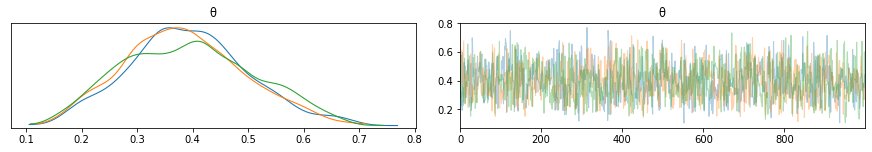

In [49]:
az.plot_trace(trace);

Результат трассировки можно представить в числовом виде. ля этого можно воспользо- ваться функцией <code>az.summary</code>, которая возвращает объект DataFrame библиотеки pandas:

In [50]:
az.summary(trace)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
θ,0.392,0.115,0.18,0.602,0.003,0.002,1432.0,1432.0,1444.0,1778.0,1.0


Здесь мы получаем среднее значение (mean), стандартное отклонение (sd) и интервал 94 % плотности апостериорного распределения (ПАР – hpd 3 % и hpd 97 %). Остальные  метрики относятся к диагностированию выборок (о них будем говорить значительно позднее или никогда :)). 

Давайте разберемся, что такое  ПАР.

Результатом байесовского анализа является апостериорное распределение, а вся информация о параметрах исследуемого набора данных и модели содержится в апостериорном распределении. Таким образом, обобщая апостериорное распределение, мы обобщаем логические выводы о модели и о данных. Общепринятым практическим методом является отчет по каждому параметру с указанием среднего значения (или медианы) для получения общего представления о размещении распределения и некоторой меры, например такой, как стандартное (среднеквадратическое) отклонение, а также для получения представления о вариации, следовательно, о неопределенности полученной оценки. <br>
Стандартное отклонение хорошо подходит для распределений нормального типа, но может оказаться ошибочным для других типов распределений, таких как асимметричные распределения.

Широко применяемым приемом для обобщения размаха апостериорного распределения является использование интервала плотности апостериорного распределения (Highest-Posterior Density – HPD). Интервал плотности апостериорного распределения (ПАР) – это самый короткий интервал, содержащий определенную часть плотности распределения. Чаще всего применяется интервал ПАР 95 %, часто дополняемый 50%-ным интервалом ПАР. Если интер- вал ПАР 95 % для некоторого анализа лежит в пределах [2,5], то для исследуемых данных и используемой модели можно считать, что рассматриваемый параметр имеет значение в интервале от 2 до 5 с вероятностью 0.95.

Почему ArviZ установлено 94%, а не 95%, а просто так удобнее, меньше цифр (100-96)/2=3. Падеюсь понятно почему появились и что значат цифры hpd_3% и hpd_97%. 

Визуально можно построить апостериорное распределения для лучшего результата (максимальной высоты) использую команду <code>az.plot_posterior</code> с отображением ПАР 94% в виде толстой черной линии.

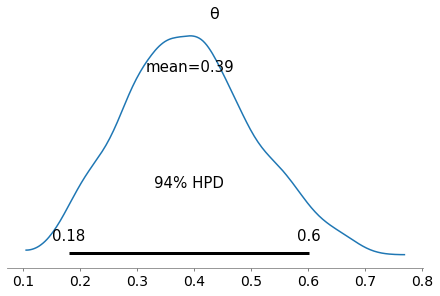

In [51]:
az.plot_posterior(trace);

Если наша монета симетрична,то можно утверждать практически, что любое значение в интервале [0.45, 0.55] будет практически равным 0.5 и представлять собой приемлемое решение нашей задачи. 

Этот интервал называют пространством практической равнозначности (ППР) (Region of Practical Equivalence – ROPE). После определения ППР, сравниваем его с плотностью апостериорного распределения (ПАР). 

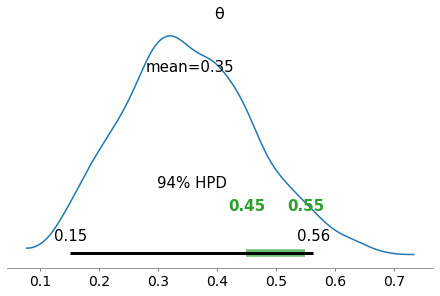

In [8]:
az.plot_posterior(trace, rope=[0.45, .55]);

При таком сравнении возможны как минимум три варианта:
<ul>
<li>
ППР не пересекается с ПАР, поэтому можно утверждать, что монета несимметрична;
</li>
<li>
    ППР полностью включает в себя весь интервал ПАР, поэтому можно утверждать, что монета симметрична;
</li>
<li>
        ППР частично пересекается с ПАР, при этом невозможно точно определить симметричность или несимметричность монеты
</li>
</ul>

Внимание! Не существует какого-либо суперуниверсального правила, соответствующего намерениям и предположениям каждого испытателя. Любые решения субъективны по своей природе, и наша цель – определить самые обоснованные (то есть принятые на основе наиболее полной информации) воз- можные решения, соответствующие нашим целям.

Кроме того, можно использовать другой инструмент, помогающий принять решение, – сравнение апостериорного распределения с эталонным значением (конечно, если оно существует).

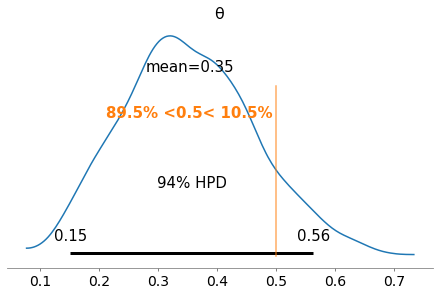

In [10]:
az.plot_posterior(trace, ref_val=0.5);